In [39]:
#essential imports
import pandas as pd
import numpy as np

import datetime as dt
import time

# Strict JSON conversion
import json 
import gzip 

#garbage collector
import gc

startyear=1990
startmonth=1

cps = 1
datapath = 'DATA/review_filtered/'
f_subjects = datapath+'movie_reviews_matched_'+str(cps)+'cps.csv'
f_controls = datapath+'movie_reviews_matched_'+str(cps)+'cps_ctrls.csv'

# Load data

In [2]:
subjects_actors = pd.read_csv(f_subjects).drop('Unnamed: 0',axis=1)
subjects_actors = subjects_actors.rename(columns={'reviewTime' : 'strReviewTime'})
subjects_actors.head(3)

,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name,death date
0,308659,0792840461,2006-04-07,4.0,"[1, 3]",The orginal,The Original and the best-not much to say read...,jack weston,1996-05-03
1,308660,0792840461,2013-03-24,5.0,"[0, 0]",Steve McQueen invented cool,This was a great movie Steve McQueen invented ...,jack weston,1996-05-03
2,308661,0792840461,2014-04-05,4.0,"[1, 1]",Where The Dough Is,"Everybody knows banks, whether in storefronts,...",jack weston,1996-05-03


In [4]:
controls_actors = pd.read_csv(f_controls).drop('Unnamed: 0',axis=1)
controls_actors = controls_actors.rename(columns={'reviewTime' : 'strReviewTime'})
controls_actors.head(3)

,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name
0,827321,630327417X,2009-10-15,5.0,"[0, 1]",Great Movie,Nothing bad to say. Dvd came quickly and in gr...,michael hynson
1,827322,630327417X,2000-09-16,5.0,"[0, 0]",endless summer,its just to good for words!,michael hynson
2,827323,630327417X,2005-03-03,1.0,"[5, 58]",A very disappointed lover of documentaries,I feel obligated to warn you-as I wish I was w...,michael hynson


# Convert dates to timestamps / years

Convert dates to year and extract and set aside actor<-> deathdates

In [5]:
subjects_actors.head()

,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name,death date
0,308659,0792840461,2006-04-07,4.0,"[1, 3]",The orginal,The Original and the best-not much to say read...,jack weston,1996-05-03
1,308660,0792840461,2013-03-24,5.0,"[0, 0]",Steve McQueen invented cool,This was a great movie Steve McQueen invented ...,jack weston,1996-05-03
2,308661,0792840461,2014-04-05,4.0,"[1, 1]",Where The Dough Is,"Everybody knows banks, whether in storefronts,...",jack weston,1996-05-03
3,308662,0792840461,2012-12-21,2.0,"[3, 3]","great movie,but PLEASE avoid this copy.",an all-time great movie and one of my favorite...,jack weston,1996-05-03
4,308663,0792840461,2013-05-12,5.0,"[0, 0]",It's McQueen,Fans of a rough and tough McQueen know that th...,jack weston,1996-05-03


,monthDiff,death date
0,76,1996-05-03
1,76,1996-05-03
2,76,1996-05-03
3,76,1996-05-03
4,76,1996-05-03
5,76,1996-05-03
6,76,1996-05-03
7,76,1996-05-03
8,76,1996-05-03
9,76,1996-05-03


In [44]:
#counts = subjects_actors.groupby('actor name').count()
#subjects_actors['death date'] = pd.to_datetime('2001').year

''' Takes a serie !
'''
def strdateToMonth(date) : 
    year = int(str(date)[:4])
    month = int(str(date)[5:7])
    assert(month <= 12 and month >= 1)
    return (month - startmonth) + (year - startyear)*12 

''' Takes a serie !
'''
def strdateToYear(date) : 
    return int(str(date)[:4])

# SUBJECTS
subjects_actors['reviewMonth'] = subjects_actors['strReviewTime'].apply(strdateToMonth)
subjects_actors['reviewYear'] = subjects_actors['strReviewTime'].apply(strdateToYear)
subjects_actors['reviewTime'] = pd.to_datetime(subjects_actors['strReviewTime'])
subjects_actors['death month'] = subjects_actors['death date'].apply(strdateToMonth)
subjects_actors['death year'] = subjects_actors['death date'].apply(strdateToYear)
subjects_actors['death date'] = pd.to_datetime(subjects_actors['death date'])

# CONTROLS
controls_actors['reviewMonth'] = controls_actors['strReviewTime'].apply(strdateToMonth)
controls_actors['reviewYear'] = controls_actors['strReviewTime'].apply(strdateToYear)
controls_actors['reviewTime'] = pd.to_datetime(controls_actors['strReviewTime'])

Extract death dates and subjects names

In [46]:
deathdates = subjects_actors.groupby(['actor name','death date', 'death year', 'death month']).count()\
                            .reset_index()[['actor name', 'death date', 'death year', 'death month']]
sbj_names = list(deathdates['actor name'])
deathdates.head()

,actor name,death date,death year,death month
0,adriana caselotti,1997-01-19,1997,84
1,adrienne shelly,2006-11-01,2006,202
2,al martino,2009-10-13,2009,237
3,alain bashung,2009-03-14,2009,230
4,alan bates,2003-12-27,2003,167


Extract controls names

In [47]:
ctrl_names = list(set(controls_actors['actor name']))

# Pre-filtering

### Filtering on populatiry

Filter actors based on their popularity: they should be mentioned at least once in the reviews. It is a way to be sure the reviewers know the actor.

In [48]:
thresh_pop = 1

def mentionsName(row) : 
    if type(row['reviewText']) is str :
        names = row['actor name'].split(' ')
        text =  row['reviewText'].lower()
        # can mention only name or surname
        #return row['actor name'] in row['reviewText']
        for name in names : 
            if name in text : 
                return True
        return False
    else : return False

In [49]:
subjects_actors.head()

,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name,death date,reviewYear,reviewTime,death year,mentionned,monthDiff,reviewMonth,death month
0,308659,0792840461,2006-04-07,4.0,"[1, 3]",The orginal,The Original and the best-not much to say read...,jack weston,1996-05-03,2006,2006-04-07,1996,False,76,195,76
1,308660,0792840461,2013-03-24,5.0,"[0, 0]",Steve McQueen invented cool,This was a great movie Steve McQueen invented ...,jack weston,1996-05-03,2013,2013-03-24,1996,False,76,278,76
2,308661,0792840461,2014-04-05,4.0,"[1, 1]",Where The Dough Is,"Everybody knows banks, whether in storefronts,...",jack weston,1996-05-03,2014,2014-04-05,1996,False,76,291,76
3,308662,0792840461,2012-12-21,2.0,"[3, 3]","great movie,but PLEASE avoid this copy.",an all-time great movie and one of my favorite...,jack weston,1996-05-03,2012,2012-12-21,1996,False,76,275,76
4,308663,0792840461,2013-05-12,5.0,"[0, 0]",It's McQueen,Fans of a rough and tough McQueen know that th...,jack weston,1996-05-03,2013,2013-05-12,1996,False,76,280,76


In [50]:
subjects_actors['mentionned'] = subjects_actors.apply(mentionsName, axis=1)
subjects_actors.shape, subjects_actors[subjects_actors['mentionned']==True].shape

((597276, 16), (130234, 16))

In [51]:
## Not necessarily needed, count of mentions are still in the reviews dataframe
##
sbj_popular = subjects_actors[subjects_actors['mentionned']==True]
sbj_popular = sbj_popular.groupby('actor name').count()['asin']
print(len(sbj_names), " reduced to", sbj_popular.shape)
sbj_popular.sort_values(ascending=False)[:10]

501  reduced to (460,)


actor name
james stewart        4135
paul newman          3119
charlton heston      3031
gregory peck         2618
marlon brando        2592
jack lemmon          2367
james garner         2347
katharine hepburn    2293
robert mitchum       2089
charles bronson      2028
Name: asin, dtype: int64

In [52]:
controls_actors['mentionned'] = controls_actors.apply(mentionsName, axis=1)
controls_actors.shape, controls_actors[controls_actors['mentionned']==True].shape

((285071, 12), (42178, 12))

In [53]:
## Not necessarily needed, count of mentions are still in the reviews dataframe
##
ctl_popular = controls_actors[controls_actors['mentionned']==True]
ctl_popular = ctl_popular.groupby('actor name').count()['asin']
print(len(ctrl_names), " reduced to", ctl_popular.shape)
ctl_popular.sort_values(ascending=False)[:10]

2419  reduced to (1215,)


actor name
matt damon            6017
steve martin          3266
tyler perry           2870
ian anderson          1213
laurence fishburne    1198
liev schreiber        1060
michelle williams     1058
marc m                 896
maggie gyllenhaal      867
robert taylor          749
Name: asin, dtype: int64

### Filtering on date (2004-2013)

In [54]:
start = 1996
end = 2014

print('original size : ', subjects_actors.shape)
subjects_inTime = subjects_actors[    (subjects_actors['death year']>=start) \
                                    & (subjects_actors['death year']<=end)]
print('filtered size : ', subjects_inTime.shape)
subjects_inTime.head(3)

original size :  (597276, 16)
filtered size :  (597276, 16)


,index,asin,strReviewTime,overall,helpful,summary,reviewText,actor name,death date,reviewYear,reviewTime,death year,mentionned,monthDiff,reviewMonth,death month
0,308659,0792840461,2006-04-07,4.0,"[1, 3]",The orginal,The Original and the best-not much to say read...,jack weston,1996-05-03,2006,2006-04-07,1996,False,76,195,76
1,308660,0792840461,2013-03-24,5.0,"[0, 0]",Steve McQueen invented cool,This was a great movie Steve McQueen invented ...,jack weston,1996-05-03,2013,2013-03-24,1996,False,76,278,76
2,308661,0792840461,2014-04-05,4.0,"[1, 1]",Where The Dough Is,"Everybody knows banks, whether in storefronts,...",jack weston,1996-05-03,2014,2014-04-05,1996,False,76,291,76


# Get matching features

Extract features for subjects

In [315]:
nbMonthBeforeDeath = 2
relMonthBeforeDeath = [-i for i in range(1, nbMonthBeforeDeath+1)]
relFeaturesStr = { i : 'revs'+str(i) for i in relMonthBeforeDeath}
#relFeaturesStr

In [217]:
# SUBJECTS COUNTS BY MONTH
subjects_monthly_revs = subjects_actors.groupby(['actor name','reviewMonth']).count()


''' MonthNb is relative to death time, so monthNb=-1 for deathMonth=March 
    means February
'''
def getreview_month_subjects(row, relMonth) : 
    return getreview_month(row, relMonth, subjects_monthly_revs)
def getreview_month(row, monthNb, musiciansDataframe, deathMonth=None) : 
    actor = row['actor name']
    if deathMonth==None : 
        deathMonth = int(row['death month'])
    try : 
        val = subjects_monthly_revs.loc[actor, int(deathMonth+monthNb)]['asin']
        return val
    except TypeError :
        #print('typeError cant index at -->'+str(deathmonth+monthNb)+'<--')
        return 0
    
subjects_monthly_feats = pd.DataFrame(deathdates[['actor name', 'death month']])
for i in relMonthBeforeDeath :
    subjects_monthly_feats[relFeaturesStr[i]] = subjects_monthly_feats\
                                        .apply(lambda row : getreview_month_subjects(row, i), axis=1)

subjects_monthly_feats.sort_values(by='revs-1', ascending=False)[:5]

,actor name,death month,revs-1,revs-2,revs-3
228,james garner,294,151,178,169
357,mickey rooney,291,149,156,236
140,eli wallach,293,120,138,114
389,philip seymour hoffman,289,119,106,68
282,julie harris,283,101,69,72


In [152]:
# SUBJECTS COUNTS BY YEAR
subjects_revs = subjects_actors.groupby(['actor name','reviewYear']).count()


def getreview(actor, year) : 
    try : 
        val = subjects_revs.loc[actor, year]['asin']
        return val
    except TypeError :
        return 0
    
    

# FILTER TO GET THE DEATH YEAR COUNT - 1
subjects_feats = deathdates[1:].apply(lambda row : getreview(row['actor name'], int(row['death year'])-1), axis=1)
subjects_feats = pd.DataFrame(subjects_feats, columns=['reviews'])
subjects_feats['actor name'] = deathdates['actor name']
subjects_feats['death year'] = deathdates['death year']
subjects_feats['death date'] = deathdates['death date']

subjects_feats.sort_values(by='reviews', ascending=False).head()

,reviews,actor name,death year,death date
228,2054,james garner,2014,2014-07-19
389,1550,philip seymour hoffman,2014,2014-02-02
357,1425,mickey rooney,2014,2014-04-06
140,1112,eli wallach,2014,2014-06-24
51,1057,bob hoskins,2014,2014-04-29


Extract features for controls (?)

In [235]:
controls_revs = controls_actors.groupby(['actor name','reviewMonth'])\
                                .count()['asin']\
                                .to_frame().reset_index()

In [236]:
controls_revs.sort_values(by=['actor name', 'asin'], ascending=False).head()

,actor name,reviewMonth,asin
49759,zuzana parmova,143,1
49760,zuzana parmova,168,1
49743,zuhal gencer,185,2
49740,zuhal gencer,180,1
49741,zuhal gencer,182,1


# Matching

Construct a matching function per subject

In [299]:
# copy back above
def getreview_month(row, monthNb, musiciansDataframe, deathMonth=None) : 
    actor = row['actor name']
    if deathMonth==None : 
        deathMonth = int(row['death month'])
    try : 
        val = musiciansDataframe.loc[actor, int(deathMonth+monthNb)]['asin']
        return int(val)
    except TypeError :
        #print('typeError cant index at -->'+str(deathmonth+monthNb)+'<--')
        return 0

In [319]:
subjects_monthly_feats.head()

,actor name,death month,revs-1,revs-2,revs-3
0,adriana caselotti,84,0,0,0
1,adrienne shelly,202,0,0,0
2,al martino,237,0,0,1
3,alain bashung,230,1,0,0
4,alan bates,167,6,4,0


In [320]:
def match(actorname, threshold, indexed_ctrl_revs) : 

    # extract the useful features for the subject 
    sbj_actor = subjects_monthly_feats[subjects_monthly_feats['actor name'] == actorname]
    #print(sbj_actor)
    deathmonth = int(sbj_actor['death month'])
    
    feature = [int(sbj_actor[relFeaturesStr[i]]) for i in relMonthBeforeDeath]
    print('feature : ', feature)
    
    for control in ctrl_revs.iterrows() : 
        
        # iterrows returns tuple (0, row)
        control = control[1]
        
        # Compute feature
        ctrl_feature = [getreview_month(control, i, 
                                        indexed_ctrl_revs.set_index(['actor name', 'reviewMonth']), 
                                        deathMonth=deathmonth) \
                        for i in relMonthBeforeDeath]
        
        print('ctrl_feature : ', ctrl_feature)
        
    
    return 0, 0, ctrl_revs  


In [ ]:
ctrl_revs = controls_revs.copy()
print(len(ctrl_names), len(sbj_names))

thresh = 4
ctrl_revs = controls_revs.copy()
sorted_subjects = subjects_feats.sort_values(by='reviews', ascending=False)
ctrl_list = [] # stores the name of matched controls
count_list = [] # stores the features of matched controls
matchings = []

for idx, subject_name in enumerate(sorted_subjects['actor name']):
    
    if idx%50 == 0: 
        print(idx, "out of ", len(subjects_feats['actor name']))
    
    mtch = 0
    thr = thresh

    while mtch == 0:
        
        thr += int(0.25*thr)
        
        if thr > 50 and thr < 60  : 
            print(subject_name+' reached threshold ', thr)
        if thr > 1000 and thr < 1250  : 
            print(subject_name+' reached threshold ', thr)
        if thr > 10000 : 
            print(subject_name+' reached threshold > 10000 (won\'t match)')
        
        name, count, ctrl_revs_ = match(subject_name,thr,ctrl_revs)
        ctrl_revs = ctrl_revs_.sample(frac=1) 
        
        
        if name != 0:
            #rint(subject_name+' matched with '+name)
            
            ctrl_list.append(name)
            count_list.append(count)
            matchings.append((subject_name, name))
            mtch += 1

2419 501
0 out of  500
feature :  [151, 178]
ctrl_feature :  [0, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature :  [6, 0]
ctrl_feature

ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 1]
ctrl_feature :  [0, 1]
ctrl_feature :  [0, 1]
ctrl_feature :  [0, 1]
ctrl_feature :  [0, 1]
ctrl_feature :  [0, 1]
ctrl_feature :  [0, 1]
ctrl_feature :  [0, 1]
ctrl_feature :  [0, 1]
ctrl_feature :  [0, 1]
ctrl_feature :  [0, 1]
ctrl_feature :  [0, 1]
ctrl_feature :  [0, 1]
ctrl_feature :  [0, 1]
ctrl_feature :  [0, 1]
ctrl_feature :  [0, 1]
ctrl_feature :  [0, 1]
ctrl_feature :  [0, 1]
ctrl_feature :  [2, 4]
ctrl_feature :  [2, 4]
ctrl_feature :  [2, 4]
ctrl_feature :  [2, 4]
ctrl_feature :  [2, 4]
ctrl_feature :  [2, 4]
ctrl_feature :  [2, 4]
ctrl_feature :  [2, 4]
ctrl_feature :  [2, 4]
ctrl_featur

ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]
ctrl_feature :  [50, 51]


ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]
ctrl_feature :  [0, 0]


# Results

In [22]:
ctrl_features = pd.DataFrame(ctrl_list, columns=['ctrl_name'])
ctrl_features['ctrl_reviews'] = count_list

res = pd.concat([ctrl_features.reset_index(), sorted_subjects.reset_index()], axis=1)\
            .drop('index', axis=1)
res['error'] = np.abs(res['ctrl_reviews'] - res['reviews'])/(2*(1+res['ctrl_reviews'] + res['reviews']))

res.sort_values(by='error', ascending=False).head()

,ctrl_name,ctrl_reviews,reviews,actor name,death year,death date,error
145,stuart reeder,6,45,jason robards,2000,2000-12-26,0.375000
250,willie chan,1,5,francis lederer,2000,2000-05-25,0.285714
255,józsef madaras,1,5,jane greer,2001,2001-08-24,0.285714
248,ching ching yiu,1,5,glenn quinn,2002,2002-12-03,0.285714
263,tyrone power sr,1,4,david tomlinson,2000,2000-06-24,0.250000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ddd0e5908>]], dtype=object)

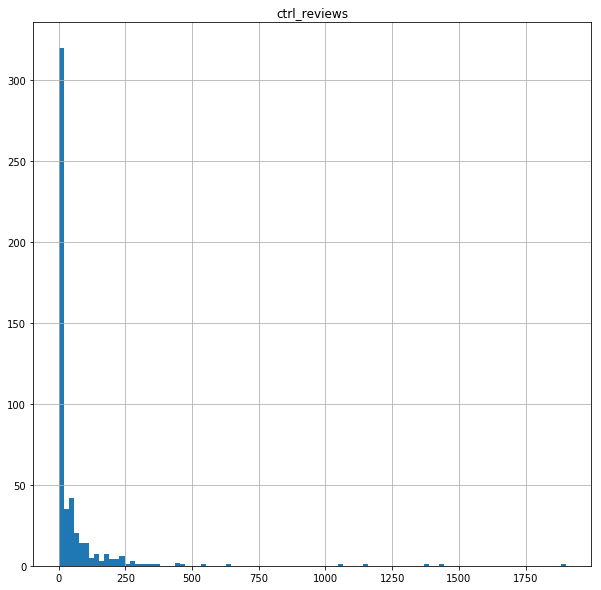

In [23]:
ctrl_features.hist(column='ctrl_reviews', figsize=[10,10], bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9ddd014780>]], dtype=object)

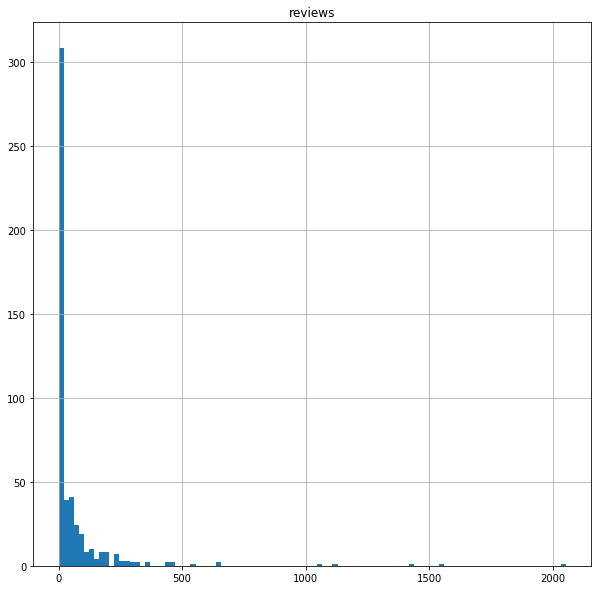

In [24]:
subjects_feats.hist(column='reviews', figsize=[10,10], bins=100)

# Export results

In [25]:
subjectsnb = str(len(sbj_names)-1)

In [26]:
subjects_actors.to_csv('DATA/reviews_cs_matched/reviews_subjects_'+subjectsnb+'.csv', index=False)

In [27]:
controls_actors.to_csv('DATA/reviews_cs_matched/reviews_controls_'+subjectsnb+'.csv', index=False)

In [28]:
res.to_csv('DATA/reviews_cs_matched/matchings_'+subjectsnb+'_feature=yearbefore.csv', index=False)